## Setup

Import the required libraries and initialize them:

In [45]:
from std_srvs.srv import Empty

In [46]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


In [47]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [48]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [49]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [50]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [51]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [52]:

rospy.init_node("recognition")


In [53]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [54]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [55]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [56]:









def gaze_point(x,y,z):

    ###Moves head to make center point of rgbd image th coordinates w.r.t.map
    ### To do: (Start from current pose  instead of always going to neutral first )
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
  #  arm_pose=arm.get_current_joint_values()
  #  arm_pose[0]=.1
  #  arm_pose[1]= -0.3
  #  arm.set_joint_value_target(arm_pose)
  #  arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    #print('i am at',trans,np.rad2deg(e)[2])
    #print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    #print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [57]:
"""# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node

def move_base(x,y,th, ref='map'):
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)"""
    

"# initialize ROS publisher\npub = rospy.Publisher('goal', PoseStamped, queue_size=10)\n\n# wait to establish connection between the navigation interface\n# move_base and navigation_log_recorder node\n\ndef move_base(x,y,th, ref='map'):\n    # input goal pose\n    goal_x = x\n    goal_y = y\n    goal_yaw =th\n\n    # fill ROS message\n    goal = PoseStamped()\n    goal.header.stamp = rospy.Time.now()\n    goal.header.frame_id = ref\n    goal.pose.position = Point(goal_x, goal_y, 0)\n    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)\n    goal.pose.orientation = Quaternion(*quat)\n    # publish ROS message\n    pub.publish(goal)"

In [58]:
arm.set_named_target('go')
arm.go()

True

In [59]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [60]:
#NOT IN REAL move_base(1.5,1.13,.5*np.pi)

In [61]:
wb_scan_table=[-0.31190874154673437,
 0.14622161533816314,
 0.08716536402861648,
 0.2986325944173752,
 -0.48043952801888556,
 -1.569982345343694,
 -1.5699016302849658,
 8.010822381621097e-05,
 0.0]
whole_body.go(wb_scan_table)

True

In [62]:
gaze_point(-0.5,-0.6,0.8)

True

In [63]:

head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-25)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

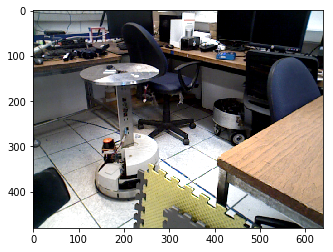

In [64]:
plt.imshow(rgbd.get_image())

# run this in terminal (TABLETOP SEGMENTATION )
#  rviz -d `rospack find hsrb_vision_samples`/config/tabletop.rvizro

In [65]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.1     # Z coordinate maximum value in the area [m]
req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 1.0  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = True    # remove the background of the segment image

res = service_client(req)
for i in range (len(res.table_array.tables)):
    print (res.table_array.tables[i].pose)

rospy.loginfo('Number of detected objects={0}'.format(
    len(   res.segmented_objects_array.table_objects_array)))
rospy.loginfo('Number of detected planes={0}'.format(
    len(res.table_array.tables)))
#(trans,rot)=tf_listener.lookupTransform('hand_palm_link', 'map', rospy.Time(0)) 

position: 
  x: 0.278068453074
  y: 0.15297113359
  z: 0.744000017643
orientation: 
  x: 0.818467915058
  y: 0.00468349084258
  z: 0.00667245266959
  w: 0.574494421482
[INFO] [1652799829.471781]: Number of detected objects=1
[INFO] [1652799829.498951]: Number of detected planes=1


In [66]:
objs_depth_centroids=[]
for i in range (len(res.segmented_objects_array.table_objects_array	)):
    print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
    for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
        cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
        cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[0] )
        pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
        points=np.zeros((pc.shape[0],3))
        points[:,0]=pc['x']
        points[:,1]=pc['y']
        points[:,2]=pc['z']
        objs_depth_centroids.append(np.mean(points,axis=0))
        print(i,j)
print objs_depth_centroids

#lets publish a tf to this centroids ( lot of false positives) !!!!


('Plane', 0, 'has', 1, 'objects')
(0, 0)
[array([ 0.44228559, -0.03355079,  1.08532232])]


In [67]:
for i in range(len(objs_depth_centroids)):
    #Table is a plane at z=.8 So we consider false positives all the centroids outside the region on axis z ( .79 , .9)
    if objs_depth_centroids[i][2] > 0 and objs_depth_centroids[i][2] <44.9: 
        static_transformStamped = geometry_msgs.msg.TransformStamped()
        broadcaster.sendTransform((objs_depth_centroids[i]),(0,0,0,1), rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
        print (i,objs_depth_centroids[i][2])


(0, 1.0853223180176992)


In [68]:
def static_tf_publish(cents):
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()
            

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w
            if xyz_map[2] > .7 and xyz_map[2] < .85:
                static_transformStamped.child_frame_id = "Object_"+str(i)+"_Table_real_lab"
                tf_static_broadcaster.sendTransform(static_transformStamped)
                print xyz_map[2]
            
            
            if xyz_map[2] > .4 and xyz_map[2] < .46:   #table 1 
                static_transformStamped.child_frame_id = "Object_"+str(i)+"_Table_1"
                tf_static_broadcaster.sendTransform(static_transformStamped)
                print xyz_map[2]
            if  xyz_map[2] < .15:   #table 1 
                static_transformStamped.child_frame_id = "Object_"+str(i)+"_Floor"
                tf_static_broadcaster.sendTransform(static_transformStamped)
                print xyz_map[2]
    return True
    


    


In [69]:
static_tf_publish(objs_depth_centroids)

0.701695269806


True



# Checkout your rviz. You should be able to see a tf marker on the centroids published above

## Now lets add some working surfaces of the collision world scene in moveit

In [70]:
def add_object(name, size, pose, orientation):
    p = PoseStamped()
    p.header.frame_id = "odom"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

    p.pose.orientation.x = orientation[0] * np.pi
    p.pose.orientation.w = orientation[1] * np.pi

    scene.add_box(name, p, size)


def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4], [2.5, 4.7, 0.78], [0.5, 0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.7, 0.49], [0.5, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.7, 0.18], [0.5, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5, 0.5])
    
    add_object("table_big", [1.7, 0.13, 0.7], [0.95, 1.9, 0.34], [0.5, 0.5])
    add_object("table_small", [0.5, 0.01, 0.4], [0.1, 1.9, 0.61], [0.5, 0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5, 0.5])    
    return True

In [71]:
scene = moveit_commander.PlanningSceneInterface()
scene_pub = rospy.Publisher('planning_scene',
                                         moveit_msgs.msg.PlanningScene,
                                         queue_size=5)


In [72]:
publish_scene()


True

In [73]:
## robot to neutral pose
head.set_named_target('neutral')
head.go()
arm.set_named_target('neutral')
arm.go()

True

In [74]:
scene.remove_world_object()


In [75]:
## we already have a object pose belief. Let's take gripper to it
xyz_map,quat_map= listener.lookupTransform(  'map','Object_2_Table_real_lab',rospy.Time(0))
xyz_map


[-0.8830639917963695, -0.7080725403245534, 0.7359126214088914]

In [76]:
wb=whole_body.get_current_joint_values()
wb

[-0.3108782375864685,
 0.14537729908437194,
 0.09541218281642427,
 5.1918904476004266e-05,
 -0.00030452801888536385,
 2.6654656306135394e-05,
 -1.5699716302849658,
 0.00046110822381617567,
 0.0]

In [77]:
wb[2]=-1.57
whole_body.go(wb)

True

In [78]:
av=arm.get_current_joint_values()
av[0]+=0.3
av[1]+=-0.3
arm.go(av)
#hv=head.get_current_joint_values()
#hv[0]=0.5*np.pi
#hv[1]=-.6
#head.go(hv)

True

In [79]:
grasp_from_table_lab=[0.2999901001773884,
 -0.9103385280188854,
 -6.534534369384559e-05,
 -0.5923696302849657,
 0.02078810822381616,
 0.0]


In [80]:
arm.go(grasp_from_table_lab)

True

In [81]:
av=arm.get_current_joint_values()
av[0]=0.25
arm.go(av)

True

In [82]:
base_vel_pub = rospy.Publisher('/hsrb/command_velocity', Twist, queue_size=1)
def move_abs(vx,vy,vw, time=0.05):
    start_time = get_current_time_sec() 
    while get_current_time_sec() - start_time < time: 
        twist = Twist()
        twist.linear.x = vx
        twist.linear.y = vy
        twist.angular.z = vw / 180.0 * np.pi  
        base_vel_pub.publish(twist)
def get_current_time_sec():
    return rospy.Time.now().to_sec()

In [83]:
## Find pose of hand relative to object using tfs
pose, quat =   listener.lookupTransform(   'hand_palm_link', 'Object_2_Table_real_lab',rospy.Time(0))
pose

[-0.07784674754673249, 0.12152718184552558, -0.024673943169804646]

In [44]:
while pose[2] >= 0.091:
            
            if pose[1] > 0.025:
                print ('drift correct   -')
                move_abs(0.00,-0.01,0, 0.051)   #GRADOS! WTF , DOCKER SEEMS TO WORK THAT WAY
            if pose[1] < -0.025:
                print ('drift correct   +')
                move_abs(0.00, 0.01,0, 0.051) #GRADOS! WTF , 
            
            else:
            
            
                print ('getting close')
                move_abs(0.0251,0,0,0.051)
            pose, quat =   listener.lookupTransform(   'hand_palm_link', 'Object_2_Table_real_lab',rospy.Time(0))

            #rospy.sleep(0.1)    

getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
getting close
gettin

In [313]:
move_ba

NameError: name 'move_ba' is not defined

In [314]:
wb_p=whole_body.get_current_pose()
wb_p

header: 
  seq: 0
  stamp: 
    secs: 1652798096
    nsecs: 377418041
  frame_id: "odom"
pose: 
  position: 
    x: -0.360127571593
    y: -0.411244501163
    z: 0.795481553221
  orientation: 
    x: 0.455110128336
    y: -0.508625452745
    z: 0.497919923633
    w: 0.535023989701

In [ ]:
clear_octo_client()


In [ ]:
wb_p=whole_body.get_current_pose()
pose,quat=pose_2_np(wb_p)
tf.transformations.euler_from_quaternion(quat),pose
wb_t=wb_p
wb_t.pose.position.x= xyz_map[0]
wb_t.pose.position.y= xyz_map[1]
wb_t.pose.position.z=1
wb_t.pose.orientation.w = 0.433
wb_t.pose.orientation.x = -0.589
wb_t.pose.orientation.y =  -0.429
wb_t.pose.orientation.z =  -0.529



In [ ]:
#scene.remove_world_object()

whole_body.set_pose_target(wb_t)
whole_body.go()

In [ ]:
#scene.remove_world_object()

whole_body.set_pose_target(wb_t)
whole_body.go()

In [ ]:
arm.set_named_target('neutral')
arm.go()

head.set_named_target('neutral')
head.go()

In [ ]:
arm.set_named_target('neutral')
arm.go()

In [ ]:
av=arm.get_current_joint_values()

In [ ]:
arm.get_active_joints()


In [ ]:
arm.get_current_pose()

In [ ]:
wb_p=whole_body.get_current_pose()
pose,quat=pose_2_np(wb_p)
tf.transformations.euler_from_quaternion(quat),pose
wb_t=wb_p
#wb_t.pose.position.x= xyz_map[0]
#wb_t.pose.position.y= xyz_map[1]
#wb_t.pose.position.z=.8
wb_t.pose.orientation.w = 0.55
wb_t.pose.orientation.x = -0.47
wb_t.pose.orientation.y =  0.46
wb_t.pose.orientation.z =  .5



In [ ]:
whole_body.set_pose_target(wb_t)
whole_body.go()

In [ ]:
arm.get_current_joint_values()

In [ ]:
wbv=whole_body.get_current_joint_values()
wbv[2]+=-0.5*np.pi
whole_body.go(wbv)

In [ ]:
wbv=whole_body.get_current_joint_values()
wbv

In [ ]:
clear_octo_client()

In [ ]:
arm

In [ ]:
arm.get_current_joint_values()

In [ ]:
av_delive= arm.get_current_joint_values()

In [ ]:
av_delive

In [ ]:
arm.go(av_delive)

In [ ]:
whole_body.get_current_joint_values()

In [ ]:
xyz_map,quat_map= listener.lookupTransform(  'map','base_footprint',rospy.Time(0))
xyz_map